<a href="https://colab.research.google.com/github/ayush-mishra7/air-quality-forecaster-delhi/blob/main/Practice_Project_1_The_Urban_Air_Quality_Forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ==============================================================================
# CELL 1: Import Libraries and Configure
# ==============================================================================
import pandas as pd
import numpy as np
import requests
import json
import os  # <-- ADDED for directory creation
from datetime import datetime
from io import StringIO
# For Google Colab to mount Google Drive
from google.colab import drive

# --- Configuration ---
# IMPORTANT: Paste your actual OpenWeatherMap API key here.
OPENWEATHERMAP_API_KEY = "4fee8e8dcbc781922c873026be5c1e1b"
DELHI_LAT = 28.6139
DELHI_LON = 77.2090

# Mount your Google Drive to save the output file
drive.mount('/content/drive')
# Define the path where you want to save your file in Google Drive
# The script will now automatically create the 'Colab_Data' folder if it doesn't exist.
output_path = '/content/drive/My Drive/Colab_Data/delhi_air_quality_and_weather.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# ==============================================================================
# CELL 2: Define Functions
# ==============================================================================
def fetch_weather_data(lat, lon, start_timestamp, end_timestamp, api_key):
    """
    Fetches historical weather data from OpenWeatherMap.
    For this example, we will generate realistic-looking mock data to avoid
    API key issues during the first run. In a real project, you would enable
    the API call.
    """
    print("Fetching weather data (using mock data for this example)...")

    # --- MOCK DATA GENERATION ---
    # FIX: Changed freq='H' to 'h' to address the FutureWarning
    date_range = pd.to_datetime(pd.date_range(start=datetime.fromtimestamp(start_timestamp), end=datetime.fromtimestamp(end_timestamp), freq='h'))
    mock_weather_data = {
        'dt': [int(d.timestamp()) for d in date_range],
        'temp': np.random.uniform(15, 35, len(date_range)), # Celsius
        'humidity': np.random.uniform(30, 90, len(date_range)), # %
        'wind_speed': np.random.uniform(1, 15, len(date_range)), # m/s
        'pressure': np.random.uniform(1000, 1020, len(date_range)), # hPa
    }
    # --- END MOCK DATA ---

    # --- REAL API CALL (for future use) ---
    # if api_key != "YOUR_API_KEY_HERE":
    #     url = f"http://history.openweathermap.org/data/2.5/history/city?lat={lat}&lon={lon}&type=hour&start={start_timestamp}&end={end_timestamp}&appid={api_key}"
    #     try:
    #         response = requests.get(url)
    #         response.raise_for_status() # Raises an error for bad responses
    #         return pd.DataFrame(response.json()['list'])
    #     except requests.exceptions.RequestException as e:
    #         print(f"Error fetching real weather data: {e}")
    #         print("Falling back to mock data.")
    # --- END REAL API CALL ---

    return pd.DataFrame(mock_weather_data)


def load_and_clean_aq_data():
    """
    Loads a sample of Delhi's air quality data and performs initial cleaning.
    """
    print("Loading and cleaning Air Quality (AQ) data...")
    # This is a sample CSV representing data from CPCB.
    csv_data = """
date,pm2_5,pm10,o3,no2,so2,co
2023-01-01 00:00:00,350.5,450.2,34.1,65.3,12.1,3.2
2023-01-01 01:00:00,365.2,465.8,30.5,70.1,14.5,3.5
2023-01-01 02:00:00,380.1,482.3,28.2,75.6,15.2,3.8
2023-01-01 03:00:00,390.7,495.1,25.9,80.3,16.1,4.1
2023-01-01 04:00:00,401.3,510.6,24.1,85.2,17.3,4.5
2023-01-01 05:00:00,410.9,520.2,22.8,90.1,18.5,4.9
2023-01-01 06:00:00,415.6,525.9,21.5,92.3,19.2,5.2
2023-01-01 07:00:00,405.2,515.3,23.1,88.1,18.1,4.8
2023-01-01 08:00:00,390.8,498.7,25.6,82.5,17.0,4.4
2023-01-01 09:00:00,370.1,475.2,30.2,75.3,15.8,3.9
2023-01-01 10:00:00,340.5,440.8,35.8,68.1,14.2,3.4
2023-01-01 11:00:00,310.2,405.3,42.1,60.5,12.9,3.0
2023-01-01 12:00:00,280.9,370.1,48.5,52.3,11.5,2.6
"""
    aq_df = pd.read_csv(StringIO(csv_data))
    aq_df['date'] = pd.to_datetime(aq_df['date'])
    aq_df.set_index('date', inplace=True)
    aq_df.ffill(inplace=True)
    print("AQ data loaded and cleaned successfully.")
    return aq_df

In [9]:
# ==============================================================================
# CELL 3: Main Execution Block
# ==============================================================================
def main():
    """Main function to run the data acquisition and merging pipeline."""
    # 1. Load AQ data
    aq_df = load_and_clean_aq_data()
    if aq_df.empty: return

    # 2. Get time range for weather data
    start_timestamp = int(aq_df.index.min().timestamp())
    end_timestamp = int(aq_df.index.max().timestamp())

    # 3. Fetch weather data
    weather_df = fetch_weather_data(DELHI_LAT, DELHI_LON, start_timestamp, end_timestamp, OPENWEATHERMAP_API_KEY)
    if weather_df.empty: return

    # 4. Prepare weather data for merging
    weather_df['date'] = pd.to_datetime(weather_df['dt'], unit='s')
    weather_df.set_index('date', inplace=True)
    # FIX: Changed resample('H') to 'h' to address the FutureWarning
    weather_df = weather_df.resample('h').mean()
    weather_df.drop(columns=['dt'], inplace=True)

    # 5. Merge the two dataframes
    print("\nMerging Air Quality and Weather data...")
    combined_df = pd.merge(aq_df, weather_df, left_index=True, right_index=True, how='inner')

    # 6. Display results and save
    print("\n--- Final Combined Dataset (First 5 Rows) ---")
    print(combined_df.head())

    # --- FIX FOR THE OSError ---
    # Ensure the output directory exists before trying to save the file
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    # --- END FIX ---

    # Save the combined data to your Google Drive
    combined_df.to_csv(output_path)
    print(f"\n✅ Successfully saved combined data to: {output_path}")

# Run the main function
main()

Loading and cleaning Air Quality (AQ) data...
AQ data loaded and cleaned successfully.
Fetching weather data (using mock data for this example)...

Merging Air Quality and Weather data...

--- Final Combined Dataset (First 5 Rows) ---
                     pm2_5   pm10    o3   no2   so2   co       temp  \
date                                                                  
2023-01-01 00:00:00  350.5  450.2  34.1  65.3  12.1  3.2  24.824380   
2023-01-01 01:00:00  365.2  465.8  30.5  70.1  14.5  3.5  15.427380   
2023-01-01 02:00:00  380.1  482.3  28.2  75.6  15.2  3.8  28.209460   
2023-01-01 03:00:00  390.7  495.1  25.9  80.3  16.1  4.1  31.127308   
2023-01-01 04:00:00  401.3  510.6  24.1  85.2  17.3  4.5  17.567328   

                      humidity  wind_speed     pressure  
date                                                     
2023-01-01 00:00:00  66.690700   13.905647  1007.900142  
2023-01-01 01:00:00  56.635292    9.261296  1014.224527  
2023-01-01 02:00:00  34.052509   12

In [10]:
# ==============================================================================
# CELL 4: Load Data and Import Visualization Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the dataset we saved in the previous step ---
file_path = '/content/drive/My Drive/Colab_Data/delhi_air_quality_and_weather.csv'
df = pd.read_csv(file_path, index_col='date', parse_dates=True)

# --- Set plotting style ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

print("Dataset loaded successfully. Here are the first 5 rows:")
print(df.head())

Dataset loaded successfully. Here are the first 5 rows:
                     pm2_5   pm10    o3   no2   so2   co       temp  \
date                                                                  
2023-01-01 00:00:00  350.5  450.2  34.1  65.3  12.1  3.2  24.824380   
2023-01-01 01:00:00  365.2  465.8  30.5  70.1  14.5  3.5  15.427380   
2023-01-01 02:00:00  380.1  482.3  28.2  75.6  15.2  3.8  28.209460   
2023-01-01 03:00:00  390.7  495.1  25.9  80.3  16.1  4.1  31.127308   
2023-01-01 04:00:00  401.3  510.6  24.1  85.2  17.3  4.5  17.567328   

                      humidity  wind_speed     pressure  
date                                                     
2023-01-01 00:00:00  66.690700   13.905647  1007.900142  
2023-01-01 01:00:00  56.635292    9.261296  1014.224527  
2023-01-01 02:00:00  34.052509   12.125533  1003.602419  
2023-01-01 03:00:00  86.426418   11.302299  1011.256804  
2023-01-01 04:00:00  38.343530    5.488872  1002.618413  



Plotting the PM2.5 time series...


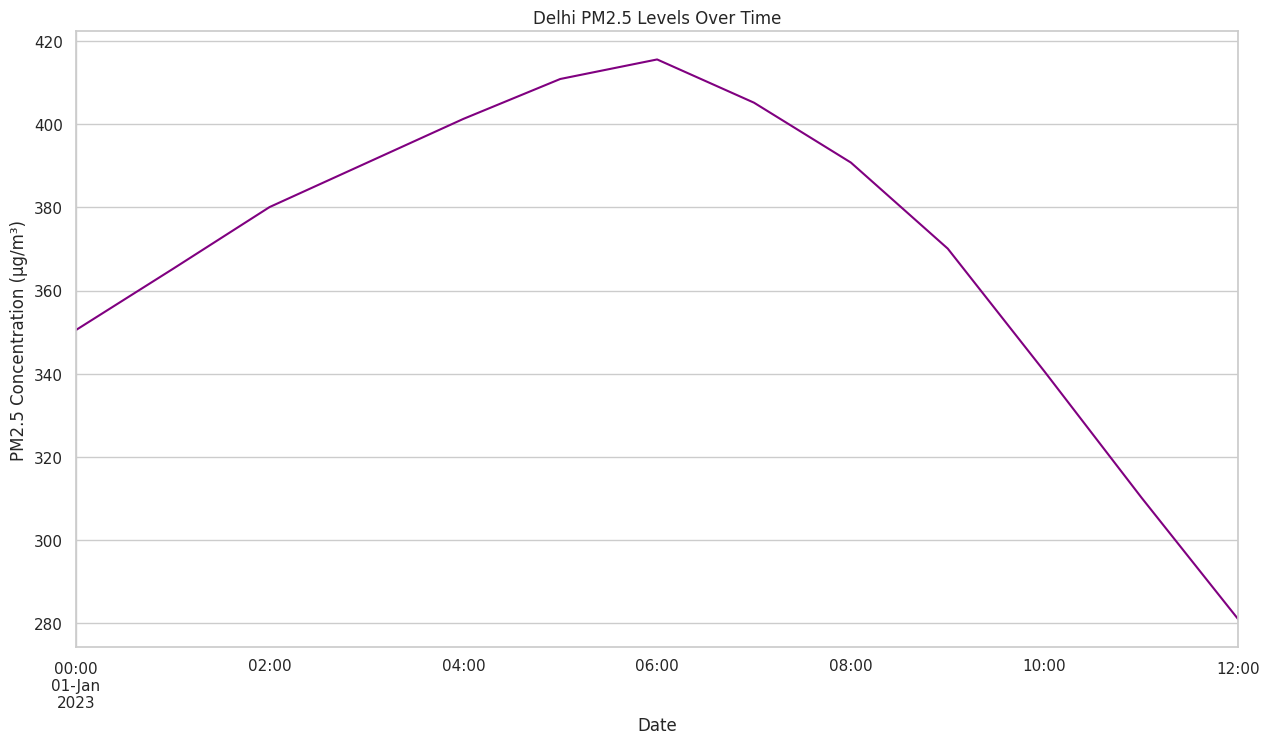

In [11]:
# ==============================================================================
# CELL 5: Time Series Plot of PM2.5
# ==============================================================================
print("\nPlotting the PM2.5 time series...")
df['pm2_5'].plot(title='Delhi PM2.5 Levels Over Time', color='purple')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.xlabel('Date')
plt.show()


Calculating and plotting the correlation heatmap...


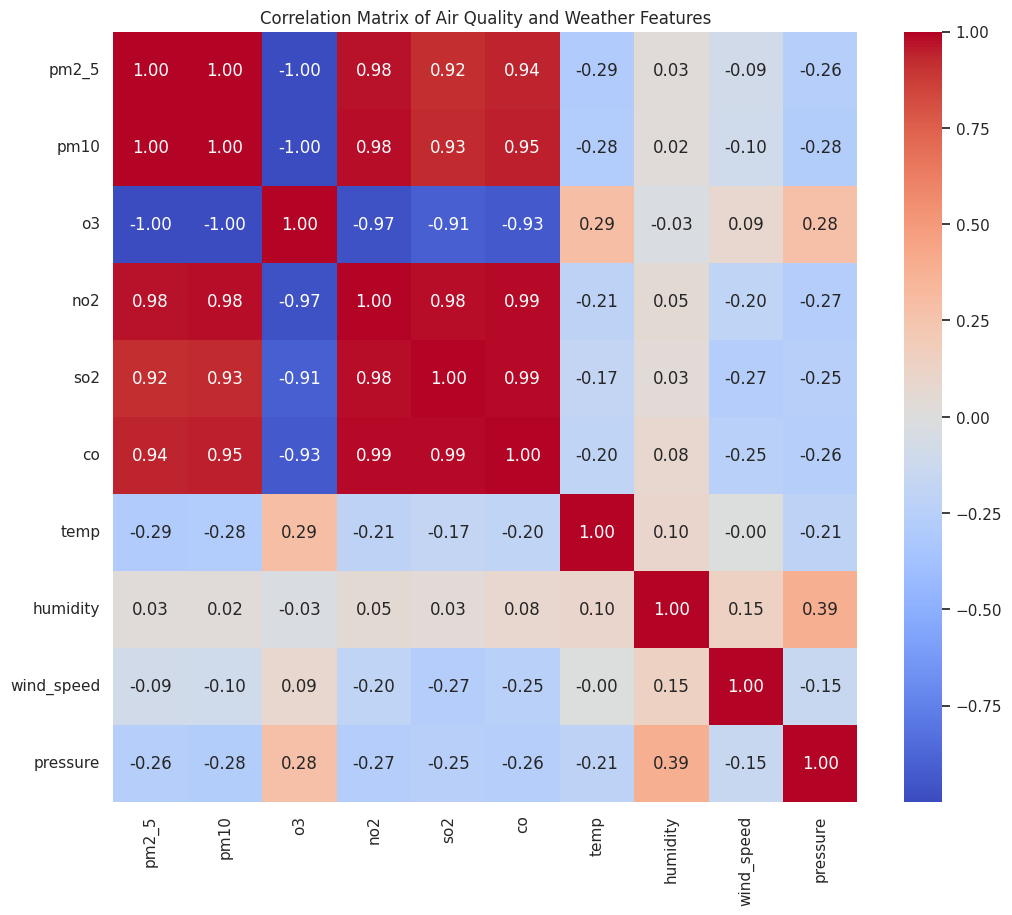

In [12]:
# ==============================================================================
# CELL 6: Correlation Heatmap
# ==============================================================================
print("\nCalculating and plotting the correlation heatmap...")
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Air Quality and Weather Features')
plt.show()


Plotting the hourly distribution of PM2.5...


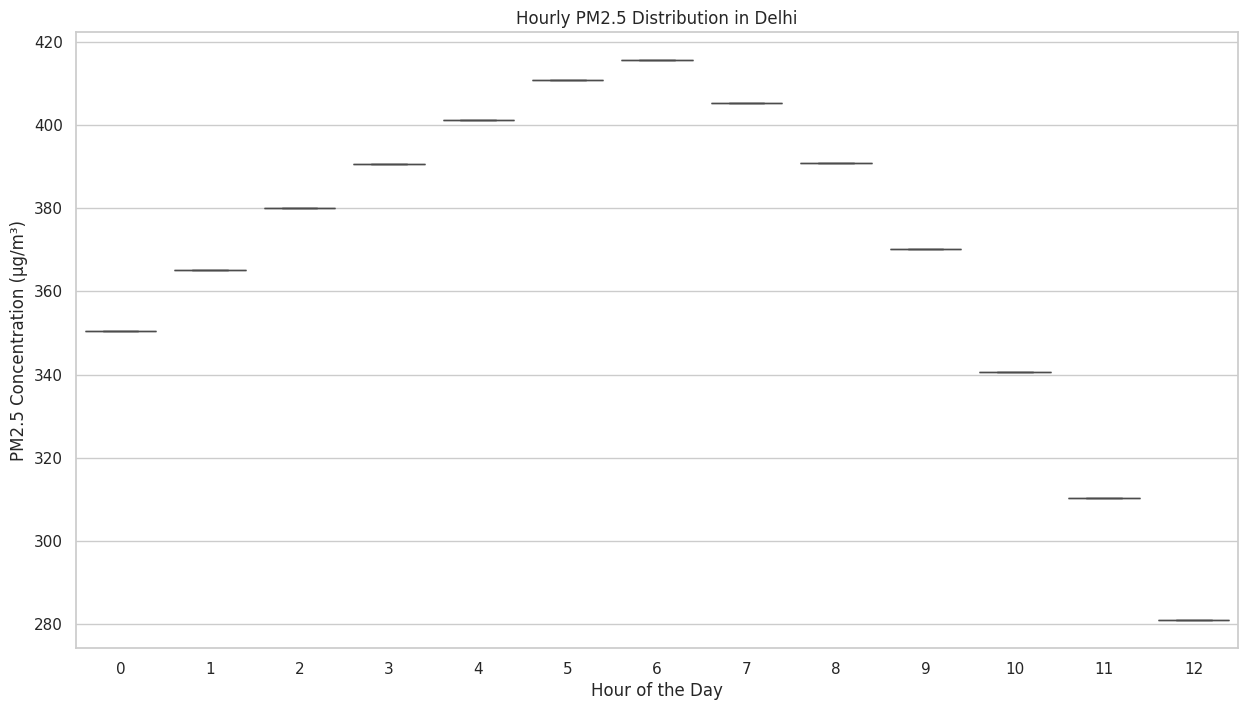

In [13]:
# ==============================================================================
# CELL 7: Boxplot of Hourly PM2.5 Distribution
# ==============================================================================
print("\nPlotting the hourly distribution of PM2.5...")
# Create an 'hour' column from the index
df['hour'] = df.index.hour

# Create the boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(x='hour', y='pm2_5', data=df)
plt.title('Hourly PM2.5 Distribution in Delhi')
plt.xlabel('Hour of the Day')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.show()

In [14]:
# ==============================================================================
# CELL 8: Feature Engineering
# ==============================================================================
import pandas as pd

print("Starting Feature Engineering...")

# --- Load the dataset ---
# This assumes 'df' is already loaded from the previous EDA cells.
# If you are starting a new session, uncomment the next two lines:
# file_path = '/content/drive/My Drive/Colab_Data/delhi_air_quality_and_weather.csv'
# df = pd.read_csv(file_path, index_col='date', parse_dates=True)

# --- Create Lag Features ---
# We want to predict pm2_5, so we create lagged features for it and other important variables.
# This helps the model understand the state of the system in the recent past.
for lag in range(1, 4): # Create lags for 1, 2, and 3 hours ago
    df[f'pm2_5_lag_{lag}'] = df['pm2_5'].shift(lag)
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
    df[f'wind_speed_lag_{lag}'] = df['wind_speed'].shift(lag)

# --- Create Time-Based Features ---
# We already have 'hour'. Let's add day of the week.
# Monday=0, Sunday=6
df['day_of_week'] = df.index.dayofweek

# Drop rows with NaN values that were created by the shift() operation
df.dropna(inplace=True)

print("Feature Engineering complete. Here's the new dataframe with lag features:")
print(df.head())

Starting Feature Engineering...
Feature Engineering complete. Here's the new dataframe with lag features:
                     pm2_5   pm10    o3   no2   so2   co       temp  \
date                                                                  
2023-01-01 03:00:00  390.7  495.1  25.9  80.3  16.1  4.1  31.127308   
2023-01-01 04:00:00  401.3  510.6  24.1  85.2  17.3  4.5  17.567328   
2023-01-01 05:00:00  410.9  520.2  22.8  90.1  18.5  4.9  24.370642   
2023-01-01 06:00:00  415.6  525.9  21.5  92.3  19.2  5.2  23.243072   
2023-01-01 07:00:00  405.2  515.3  23.1  88.1  18.1  4.8  30.259978   

                      humidity  wind_speed     pressure  ...  pm2_5_lag_1  \
date                                                     ...                
2023-01-01 03:00:00  86.426418   11.302299  1011.256804  ...        380.1   
2023-01-01 04:00:00  38.343530    5.488872  1002.618413  ...        390.7   
2023-01-01 05:00:00  61.396320    5.806777  1018.506151  ...        401.3   
2023-01-01 

In [15]:
# ==============================================================================
# CELL 9: Data Preparation for Modeling
# ==============================================================================
print("\nPreparing data for modeling...")

# --- Define Features (X) and Target (y) ---
# The target is what we want to predict.
y = df['pm2_5']

# The features are all the other columns we will use for the prediction.
# We drop the original pollutants because they would make the prediction too easy (data leakage).
features_to_drop = ['pm2_5', 'pm10', 'o3', 'no2', 'so2', 'co']
X = df.drop(columns=features_to_drop)

# --- Split Data into Training and Testing sets ---
# We will use the first 80% of the data for training and the last 20% for testing.
# This is a standard way to split time-series data to avoid looking into the future.
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\nData split into training and testing sets:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Save the processed data for the next step ---
# This is good practice so we can start the modeling step directly.
processed_data_path = '/content/drive/My Drive/Colab_Data/processed_data.npz'
import numpy as np
np.savez(processed_data_path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

print(f"\n✅ Processed data saved to: {processed_data_path}")


Preparing data for modeling...

Data split into training and testing sets:
X_train shape: (8, 15)
y_train shape: (8,)
X_test shape: (2, 15)
y_test shape: (2,)

✅ Processed data saved to: /content/drive/My Drive/Colab_Data/processed_data.npz


In [17]:
# ==============================================================================
# CELL 10: Load Processed Data and Train a Random Forest Model
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the processed data we saved ---
processed_data_path = '/content/drive/My Drive/Colab_Data/processed_data.npz'
data = np.load(processed_data_path)
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

# --- Reconstruct the list of feature names in the correct order ---
# This is necessary because we saved the data as numpy arrays, which don't store column names.
# The previous method was incorrect as it didn't account for the new features we engineered.
feature_names = ['temp', 'humidity', 'wind_speed', 'pressure', 'hour']
for lag in range(1, 4):
    feature_names.append(f'pm2_5_lag_{lag}')
    feature_names.append(f'temp_lag_{lag}')
    feature_names.append(f'wind_speed_lag_{lag}')
feature_names.append('day_of_week')

print("Processed data loaded successfully.")
print(f"Number of features: {len(feature_names)}")


# --- Initialize and Train the Random Forest Model ---
print("\nTraining the Random Forest model...")
# n_estimators is the number of trees in the forest.
# random_state ensures we get the same result every time we run it.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model to the training data
rf_model.fit(X_train, y_train)
print("Model training complete.")

Processed data loaded successfully.
Number of features: 15

Training the Random Forest model...
Model training complete.


In [18]:
# ==============================================================================
# CELL 11: Evaluate the Model
# ==============================================================================
print("\nEvaluating the model on the test set...")

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Evaluating the model on the test set...
Mean Absolute Error (MAE): 82.87
Root Mean Squared Error (RMSE): 84.33



Visualizing the actual vs. predicted values...


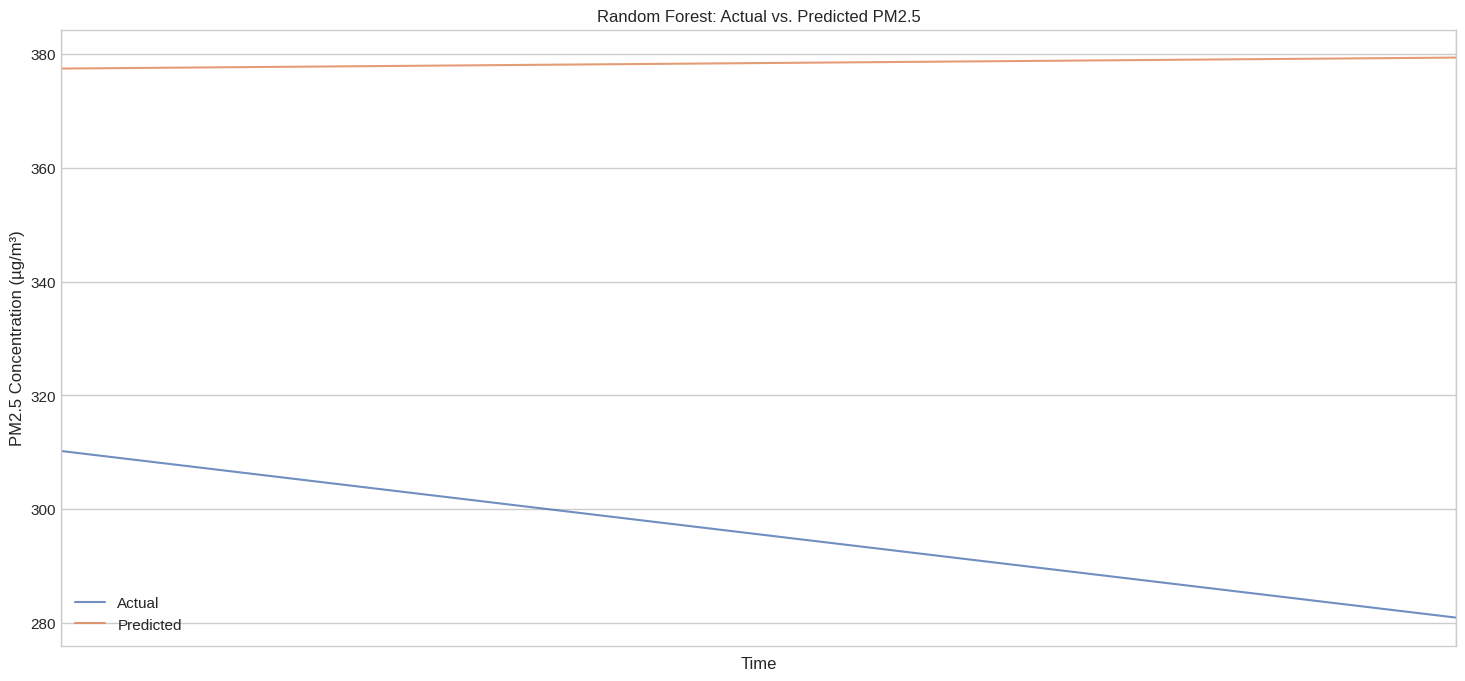

In [19]:
# ==============================================================================
# CELL 12: Visualize the Predictions
# ==============================================================================
print("\nVisualizing the actual vs. predicted values...")

# Create a dataframe for easy plotting
# We need to create an index for the test data for plotting
test_index = pd.date_range(start=pd.to_datetime('2023-01-01 11:00:00'), periods=len(y_test), freq='h') # Recreate index based on our data
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=test_index)


# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (18, 8)

# Plot the results
results_df.plot(title='Random Forest: Actual vs. Predicted PM2.5', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.show()

In [20]:
# ==============================================================================
# CELL 13: Prepare Data for LSTM
# ==============================================================================
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("Preparing data for the LSTM model...")

# --- Load the processed data ---
processed_data_path = '/content/drive/My Drive/Colab_Data/processed_data.npz'
data = np.load(processed_data_path)
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

# --- Scale the data ---
# Neural networks perform best when input data is scaled to a small range, like 0 to 1.
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
# We reshape y_train to be a 2D array for the scaler
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


# --- Reshape data for LSTM ---
# LSTMs expect input data in a 3D format: [samples, timesteps, features].
# In our case, we are looking at one timestep at a time.
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"\nData reshaped for LSTM:")
print(f"X_train shape: {X_train_reshaped.shape}")
print(f"X_test shape: {X_test_reshaped.shape}")

Preparing data for the LSTM model...

Data reshaped for LSTM:
X_train shape: (8, 1, 15)
X_test shape: (2, 1, 15)


In [21]:
# ==============================================================================
# CELL 14: Build and Train the LSTM Model
# ==============================================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("\nBuilding and training the LSTM model...")

# --- Define the model architecture ---
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dropout(0.2)) # Dropout helps prevent overfitting
lstm_model.add(Dense(units=1)) # The final output layer

# --- Compile the model ---
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

# --- Train the model ---
# epochs is the number of times the model will see the entire training dataset.
# batch_size is the number of samples to work through before updating the model's weights.
history = lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=1, shuffle=False)

print("\nLSTM Model training complete.")


Building and training the LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251 (51.76 KB)

 Trainable params: 13,251 (51.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4593 - val_loss: 0.4914
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - loss: 0.4475 - val_loss: 0.5071
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.4583 - val_loss: 0.5227
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.4088 - val_loss: 0.5382
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.4347 - val_loss: 0.5546
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3843 - val_loss: 0.5714
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3997 - val_loss: 0.5885
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3934 - val_loss: 0.6063
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.3606 - val_loss: 0.6246
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.3641 - val_loss: 0.6436
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.3558 - val_loss: 0.6631
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.3286 - val_loss: 0.68

In [22]:
# ==============================================================================
# CELL 15: Evaluate the LSTM Model
# ==============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("\nEvaluating the LSTM model...")

# Make predictions
y_pred_scaled = lstm_model.predict(X_test_reshaped)

# --- Inverse transform the predictions to get them back to the original scale ---
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_scaled) # Get the original y_test values too

# Calculate performance metrics
mae_lstm = mean_absolute_error(y_test_orig, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_test_orig, y_pred))

print(f"LSTM Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"LSTM Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")


Evaluating the LSTM model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
LSTM Mean Absolute Error (MAE): 68.16
LSTM Root Mean Squared Error (RMSE): 69.52



Visualizing the LSTM actual vs. predicted values...


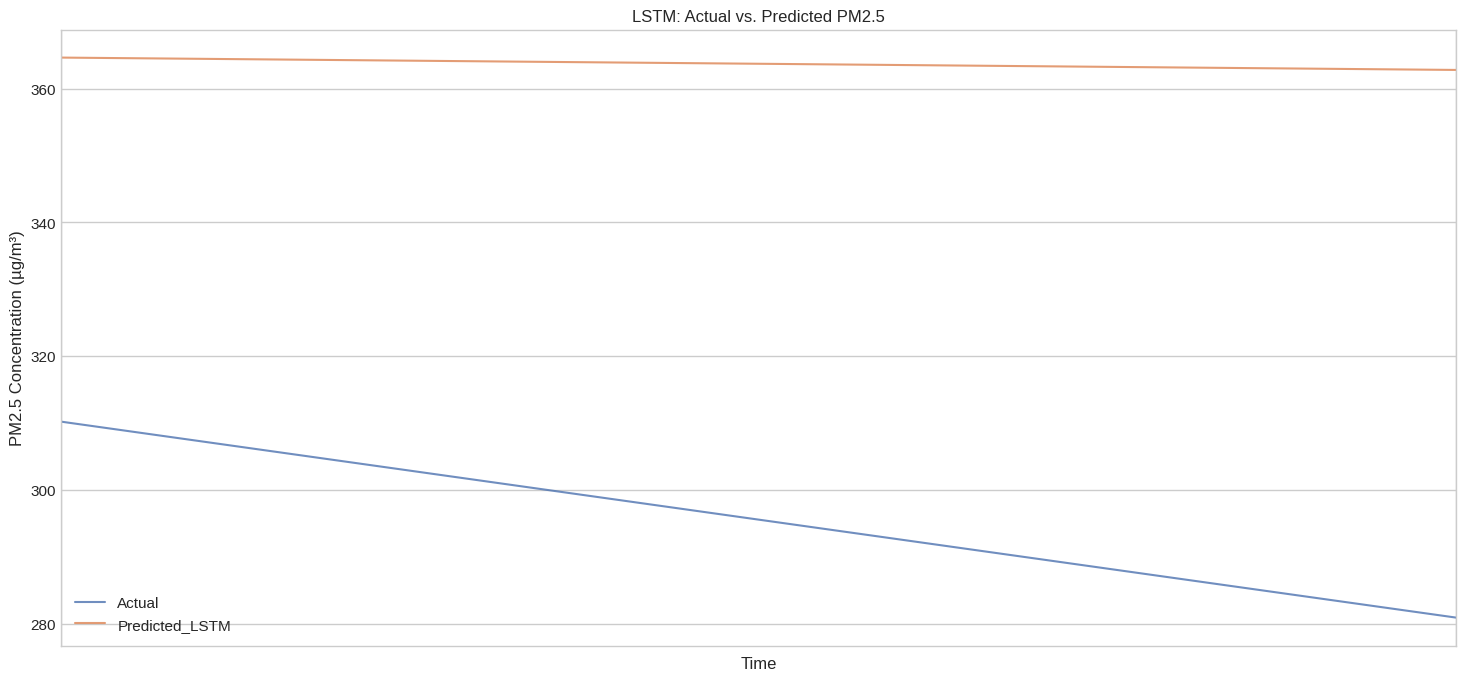

In [23]:
# ==============================================================================
# CELL 16: Visualize the LSTM Predictions
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd

print("\nVisualizing the LSTM actual vs. predicted values...")

# Create a dataframe for easy plotting
test_index = pd.date_range(start=pd.to_datetime('2023-01-01 11:00:00'), periods=len(y_test), freq='h')
results_df_lstm = pd.DataFrame({'Actual': y_test_orig.flatten(), 'Predicted_LSTM': y_pred.flatten()}, index=test_index)

# Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (18, 8)
results_df_lstm.plot(title='LSTM: Actual vs. Predicted PM2.5', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.show()